Check the correlation between the performance of grounding and VGP identification

In [1]:
% cd /home/mayu-ot/durga/Experiments/loc_iparaphrasing/

from chainercv.utils import bbox_iou, non_maximum_suppression
import chainer
import numpy as np
import json
import pandas as pd
import tables
from chainer.dataset.convert import concat_examples
from sklearn.metrics import f1_score, precision_score, recall_score
from func.datasets.datasets import get_agg_roi_df
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.metrics import edit_distance

/mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing


/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from func.datasets.datasets import BBoxDataset, PLCLCBBoxDataset, DDPNBBoxDataset, PreCompFeatDataset

In [3]:
p_bbox_data = DDPNBBoxDataset('test')
pbbox_df = p_bbox_data.df


In [4]:
df = pd.read_csv('data/phrase_pair_test.csv', index_col=0)

In [5]:
gtbbox_df.head()

ymin  xmin  ymax  xmax  n_id
image  org_phrase                                                   
390369 A gold colored street performer   125     4   431   229     0
       A person                          125     4   431   229     1
       A street performer                125     4   431   229     2
       The people                        149     1   303   327     3
       a costume                         159     1   435   235     4

In [22]:
from IPython.html.widgets import IntProgress
from IPython.display import display

def get_gtbbox(df, img_id, phr):
    ymin = df.at[(img_id, phr), 'ymin']
    xmin = df.at[(img_id, phr), 'xmin']
    ymax = df.at[(img_id, phr), 'ymax']
    xmax = df.at[(img_id, phr), 'xmax']
    return np.asarray([[ymin, xmin, ymax, xmax]])

def lget_bbox(df, img_id, phr):
    rows = df.query('image==%s'%img_id)
    dist = list(
            map(lambda x: edit_distance(phr.lower(), x), rows.phrase))
    row = rows.iloc[np.argmin(dist)]
    return np.asarray([[row.ymin, row.xmin, row.ymax, row.xmax]])

def get_ious(method='ddpn'):
    if method=='ddpn':
        p_bbox_data = DDPNBBoxDataset('test')
        pbbox_df = p_bbox_data.df
    elif method=='plclc':
        p_bbox_data = PLCLCBBoxDataset('test')
        pbbox_df = p_bbox_data.df

    gt_bbox_data = BBoxDataset('test')
    gtbbox_df = gt_bbox_data.df
        
    ip = IntProgress(min=0, max=len(df))
    display(ip)

    ious1 = []
    ious2 = []

    for i, row in df.iterrows():
        im_id, phr1, phr2 = row[['image', 'original_phrase1', 'original_phrase2']]
        p_bbox1 = lget_bbox(pbbox_df, im_id, phr1)
        p_bbox2 = lget_bbox(pbbox_df, im_id, phr2)

        gt_bbox1 = get_gtbbox(gtbbox_df, im_id, phr1)
        gt_bbox2 = get_gtbbox(gtbbox_df, im_id, phr2)

        iou1 = bbox_iou(p_bbox1, gt_bbox1)
        iou2 = bbox_iou(p_bbox2, gt_bbox2)

        ious1.append(iou1[0])
        ious2.append(iou2[0])

        ip.value = i

    plclc_ious1 = ious1
    plclc_ious2 = ious2
    return plclc_ious1, plclc_ious2

In [23]:
plclc_ious1, plclc_ious2 = get_ious(method='plclc')

IntProgress(value=0, max=81285)

In [29]:
ddpn_ious1, ddpn_ious2 = get_ious(method='ddpn')

IntProgress(value=0, max=81285)

In [7]:
import seaborn as sns
sns.set()

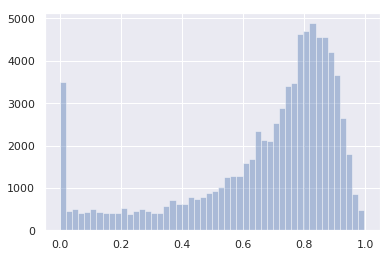

In [8]:
sns.distplot(ious1, kde=False)

In [33]:
# DDPN
def get_results(df_file, ious1, ious2):
    df = pd.read_csv(df_file)
    df['ious1'] = np.asarray(ious1)
    df['ious2'] = np.asarray(ious2)

    iou_thres = []
    f1_scores = []
    interval = 0.1
    for thres in np.arange(interval, 1+interval, interval):
        iou_mean = np.mean(df[['ious1', 'ious2']].values, axis=1)
        sub_data = df[(iou_mean >= thres-interval) & (iou_mean < thres)]
        score = f1_score(sub_data.ytrue, sub_data.ypred)
        print('%.1f-%.1f' % (thres-interval, thres), '%.2f' % (100.*score), '(%.1f%%)'%(100*len(sub_data) / len(df)))
        iou_thres.append(thres)
        f1_scores.append(100*score)
    
    return f1_scores, f1_score(df.ytrue, df.ypred) * 100

ddpn_scores, _ = get_results('bo_out/vis+lng+ddpn+mult/18-20181108-015934/res_test.csv', ddpn_ious1, ddpn_ious2)
vis_ddpn_scores, _ = get_results('bo_out/vis+ddpn/7-20181107-221739/res_test.csv', ddpn_ious1, ddpn_ious2)
lng_scores, lng_avr_score = get_results('bo_out/lng/13-20181102-020120/res_test.csv', ddpn_ious1, ddpn_ious2)
# plclc_scores, _ = get_results('bo_out/vis+lng+plclc+mult/17-20181108-050238/res_test.csv', )

0.0-0.1 72.63 (1.0%)
0.1-0.2 72.83 (0.8%)
0.2-0.3 68.15 (1.9%)
0.3-0.4 61.72 (5.0%)
0.4-0.5 65.69 (9.9%)
0.5-0.6 75.38 (10.0%)
0.6-0.7 81.08 (15.3%)
0.7-0.8 87.62 (25.5%)
0.8-0.9 92.33 (26.2%)
0.9-1.0 96.28 (4.6%)
0.0-0.1 56.45 (1.0%)
0.1-0.2 47.83 (0.8%)
0.2-0.3 39.38 (1.9%)
0.3-0.4 38.77 (5.0%)
0.4-0.5 25.30 (9.9%)
0.5-0.6 43.26 (10.0%)
0.6-0.7 54.43 (15.3%)
0.7-0.8 67.53 (25.5%)
0.8-0.9 77.39 (26.2%)
0.9-1.0 87.58 (4.6%)
0.0-0.1 74.81 (1.0%)
0.1-0.2 70.72 (0.8%)
0.2-0.3 73.93 (1.9%)
0.3-0.4 64.27 (5.0%)
0.4-0.5 70.44 (9.9%)
0.5-0.6 74.40 (10.0%)
0.6-0.7 80.56 (15.3%)
0.7-0.8 86.41 (25.5%)
0.8-0.9 90.96 (26.2%)
0.9-1.0 94.12 (4.6%)


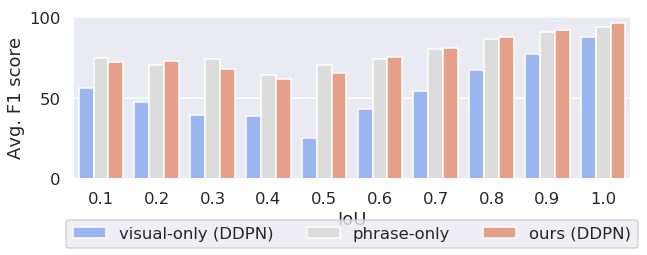

In [34]:
interval = 0.1
sns.set_context("talk")
palette=sns.color_palette("coolwarm", 3)
# palette=sns.diverging_palette(220, 20, n=5)

N = len(ddpn_scores)

lng_df = pd.DataFrame({'IoU': np.arange(interval, 1+interval, interval),
                      'Avg. F1 score': lng_scores,
                       'models': ['phrase-only']*N})

vis_ddpn_df = pd.DataFrame({'IoU': np.arange(interval, 1+interval, interval),
                      'Avg. F1 score': vis_ddpn_scores,
                       'models': ['visual-only (DDPN)']*N})

ddpn_df = pd.DataFrame({'IoU': np.arange(interval, 1+interval, interval),
                      'Avg. F1 score': ddpn_scores,
                      'models': ['ours (DDPN)']*N})

all_data = pd.concat((vis_ddpn_df, lng_df, ddpn_df))

plt.figure(figsize=(10, 3))
# plt.axhline(lng_avr_score, color='k', linestyle='--', label='phrase-only')
g = sns.barplot(x='IoU', y='Avg. F1 score', hue='models', data=all_data, palette=palette)
g.set_xticklabels(['%.1f'%x for x in np.arange(interval, 1+interval, interval)])
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.savefig('figures/cvpr/detailed_results_bar_ddpn.pdf', bbox_inches='tight')

In [35]:
# PLCLC
def get_results(df_file, ious1, ious2):
    df = pd.read_csv(df_file)
    df['ious1'] = np.asarray(ious1)
    df['ious2'] = np.asarray(ious2)

    iou_thres = []
    f1_scores = []
    interval = 0.1
    for thres in np.arange(interval, 1+interval, interval):
        iou_mean = np.mean(df[['ious1', 'ious2']].values, axis=1)
        sub_data = df[(iou_mean >= thres-interval) & (iou_mean < thres)]
        score = f1_score(sub_data.ytrue, sub_data.ypred)
        print('%.1f-%.1f' % (thres-interval, thres), '%.2f' % (100.*score), '(%.1f%%)'%(100*len(sub_data) / len(df)))
        iou_thres.append(thres)
        f1_scores.append(100*score)
    
    return f1_scores, f1_score(df.ytrue, df.ypred) * 100

plclc_scores, _ = get_results('bo_out/vis+lng+plclc+mult/17-20181108-050238/res_test.csv', plclc_ious1, plclc_ious2)
vis_plclc_scores, _ = get_results('bo_out/vis+plclc/25-20181111-060511/res_test.csv', plclc_ious1, plclc_ious2)
lng_scores, lng_avr_score = get_results('bo_out/lng/13-20181102-020120/res_test.csv', plclc_ious1, plclc_ious2)

0.0-0.1 76.90 (5.0%)
0.1-0.2 75.31 (5.7%)
0.2-0.3 74.31 (8.5%)
0.3-0.4 74.34 (14.2%)
0.4-0.5 77.73 (17.5%)
0.5-0.6 82.46 (15.2%)
0.6-0.7 88.83 (14.4%)
0.7-0.8 91.37 (12.0%)
0.8-0.9 94.81 (6.5%)
0.9-1.0 95.21 (1.2%)
0.0-0.1 45.08 (5.0%)
0.1-0.2 38.24 (5.7%)
0.2-0.3 27.77 (8.5%)
0.3-0.4 28.98 (14.2%)
0.4-0.5 35.42 (17.5%)
0.5-0.6 49.22 (15.2%)
0.6-0.7 64.17 (14.4%)
0.7-0.8 75.27 (12.0%)
0.8-0.9 85.60 (6.5%)
0.9-1.0 90.06 (1.2%)
0.0-0.1 78.67 (5.0%)
0.1-0.2 76.57 (5.7%)
0.2-0.3 77.71 (8.5%)
0.3-0.4 75.21 (14.2%)
0.4-0.5 79.09 (17.5%)
0.5-0.6 82.86 (15.2%)
0.6-0.7 89.05 (14.4%)
0.7-0.8 91.14 (12.0%)
0.8-0.9 94.88 (6.5%)
0.9-1.0 93.57 (1.2%)


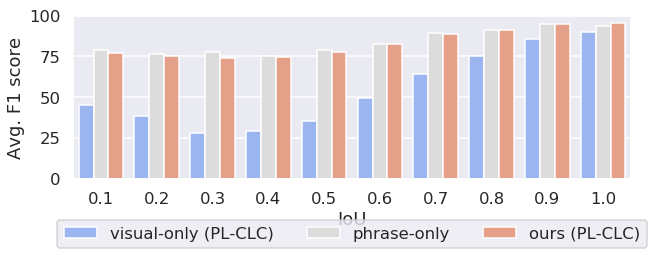

In [36]:
interval = 0.1
sns.set_context("talk")
palette=sns.color_palette("coolwarm", 3)
# palette=sns.diverging_palette(220, 20, n=5)

N = len(ddpn_scores)

lng_df = pd.DataFrame({'IoU': np.arange(interval, 1+interval, interval),
                      'Avg. F1 score': lng_scores,
                       'models': ['phrase-only']*N})

vis_plclc_df = pd.DataFrame({'IoU': np.arange(interval, 1+interval, interval),
                      'Avg. F1 score': vis_plclc_scores,
                       'models': ['visual-only (PL-CLC)']*N})

plclc_df = pd.DataFrame({'IoU': np.arange(interval, 1+interval, interval),
                      'Avg. F1 score': plclc_scores,
                      'models': ['ours (PL-CLC)']*N})

all_data = pd.concat((vis_plclc_df, lng_df, plclc_df))

plt.figure(figsize=(10, 3))
# plt.axhline(lng_avr_score, color='k', linestyle='--', label='phrase-only')
g = sns.barplot(x='IoU', y='Avg. F1 score', hue='models', data=all_data, palette=palette)
g.set_xticklabels(['%.1f'%x for x in np.arange(interval, 1+interval, interval)])
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.savefig('figures/cvpr/detailed_results_bar_plclc.pdf', bbox_inches='tight')